In [1]:
from experiments.plt_pab_fae import plt_fab_fae
from protocol.BB84EveTrainableProtocol import BB84EveTrainableProtocol
from protocol.connection_elements.Layer import SeparableLayer
from protocol.BB84Protocol import BB84Protocol
from protocol.connection_elements.MultiQubitQCLEve import MultiQubitQCLEve


init [ClassicalRegister(1, 'eve_measure'), QuantumRegister(2, 'eve_clone')]


/home/wpalka/.virtualenvs/BB84-QCL-error-correction/lib/python3.12/site-packages/qiskit/circuit/quantumcircuit.py:3428: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


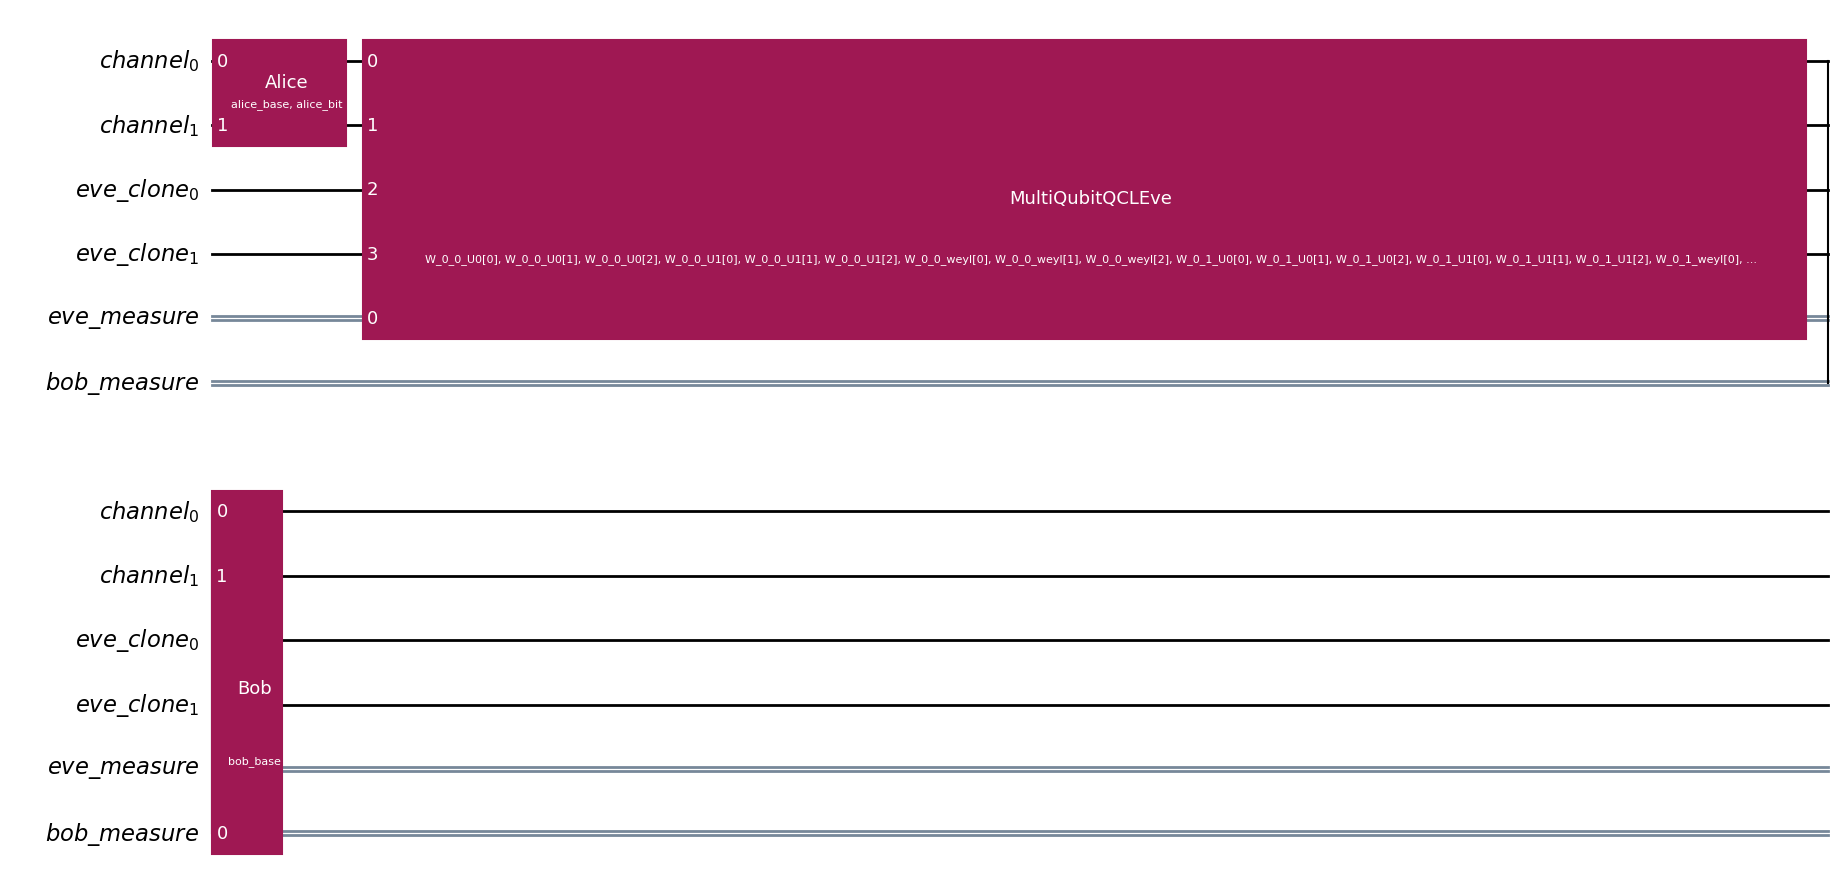

In [4]:
from protocol.connection_elements.QCLEve import QCLEve

layers = [SeparableLayer("AliceLayer"), SeparableLayer("BobLayer")]
eve = MultiQubitQCLEve()

protocol = BB84Protocol(n_bits=512, elements=[eve], channel_size=2,
                                        seed=0, )

qc, _ = protocol.qc_with_ctx()
qc.draw("mpl", expr_len=3)

In [4]:
def train():
    bob_qber, eve_qber = [], []
    for epoch in range(50):
        loss = protocol.train()
        qber = protocol.run()
        bob_qber.append(qber['bob_qber'])
        eve_qber.append(qber['eve_qber'])
        if epoch % 5 == 0:
            print(f'epoch: {epoch}, loss: {loss}, QBER: {qber}')

    return bob_qber, eve_qber

# Krok 1 - trenowanie całego obwodu
Uczymy cały obwód z docelową dokładnością Boba 0.853 (wartość kompromisowa w PCCM pomiędzy dokładnością Boba i Eve)

In [5]:
protocol.f_value = 0.853
b_q, e_q = train()

epoch: 0, loss: 0.23294925689697266, QBER: {'bob_qber': np.float64(0.19852941176470584), 'eve_qber': np.float64(0.47058823529411764)}
epoch: 5, loss: -0.5265442728996277, QBER: {'bob_qber': np.float64(0.12867647058823528), 'eve_qber': np.float64(0.4816176470588235)}
epoch: 10, loss: -0.5707868933677673, QBER: {'bob_qber': np.float64(0.22058823529411764), 'eve_qber': np.float64(0.3933823529411765)}
epoch: 15, loss: -0.7132795453071594, QBER: {'bob_qber': np.float64(0.16176470588235292), 'eve_qber': np.float64(0.2647058823529411)}
epoch: 20, loss: -0.7538126707077026, QBER: {'bob_qber': np.float64(0.17279411764705888), 'eve_qber': np.float64(0.1875)}
epoch: 25, loss: -0.7832194566726685, QBER: {'bob_qber': np.float64(0.17647058823529416), 'eve_qber': np.float64(0.19852941176470584)}
epoch: 30, loss: -0.8067398071289062, QBER: {'bob_qber': np.float64(0.18014705882352944), 'eve_qber': np.float64(0.1654411764705882)}
epoch: 35, loss: -0.826885461807251, QBER: {'bob_qber': np.float64(0.17647

<module 'matplotlib.pyplot' from '/home/pcfeng3/PycharmProjects/BB84-QCL-error-correction/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

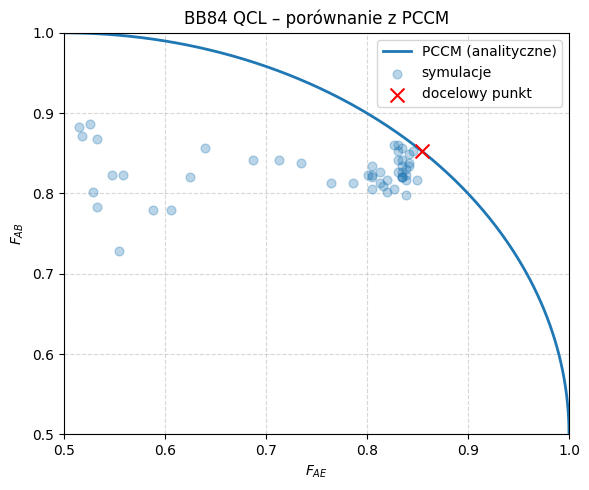

In [6]:
plt_fab_fae(b_q, e_q, 0.853)

### Wynik: udało osiągnąć się wydajność zbliżoną do PCCM

# Krok 2 - trenowanie tylko Eve, warstwy Alice i Boba zamrożone
Uczymy samą Eve, docelowa dokładność Boba to 0.8

In [ ]:
protocol.freeze_elements(layers)

In [8]:
protocol.f_value = 0.8
b_q, e_q = train()

epoch: 0, loss: -0.8216550946235657, QBER: {'bob_qber': np.float64(0.22426470588235292), 'eve_qber': np.float64(0.11397058823529416)}
epoch: 5, loss: -0.8780773282051086, QBER: {'bob_qber': np.float64(0.19117647058823528), 'eve_qber': np.float64(0.13602941176470584)}
epoch: 10, loss: -0.8880261778831482, QBER: {'bob_qber': np.float64(0.22058823529411764), 'eve_qber': np.float64(0.1029411764705882)}
epoch: 15, loss: -0.8877888321876526, QBER: {'bob_qber': np.float64(0.18014705882352944), 'eve_qber': np.float64(0.125)}
epoch: 20, loss: -0.8893327713012695, QBER: {'bob_qber': np.float64(0.22058823529411764), 'eve_qber': np.float64(0.10661764705882348)}
epoch: 25, loss: -0.8894898295402527, QBER: {'bob_qber': np.float64(0.20588235294117652), 'eve_qber': np.float64(0.11029411764705888)}
epoch: 30, loss: -0.8912692666053772, QBER: {'bob_qber': np.float64(0.2095588235294118), 'eve_qber': np.float64(0.10661764705882348)}
epoch: 35, loss: -0.8921769261360168, QBER: {'bob_qber': np.float64(0.194

<module 'matplotlib.pyplot' from '/home/pcfeng3/PycharmProjects/BB84-QCL-error-correction/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

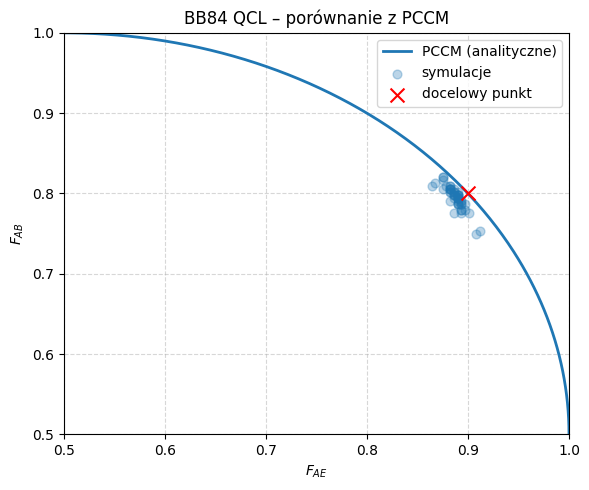

In [9]:
plt_fab_fae(b_q, e_q, 0.8)

### Wynik: Eve była w stanie poprawić swoją dokładność bez modyfikowania warst w Alice i Bobie

# Krok 3 - trenowanie warstw Alice i Boba, Eve zamrożona
Próbujemy uczyć Alice i Boba z użyciem nowej funkcji straty, która maksymalizuje jedynie dokładność Boba.

In [ ]:
protocol.freeze_elements([eve])

In [13]:
def bob_loss(target, mask, outputs):
    bob_Z = outputs["channel"][:, 0]

    sign = 1 - 2 * target.long()
    bob_f = 0.5 * (1 + sign * bob_Z)

    bob_f = bob_f[mask].mean()

    loss = -bob_f
    return loss


In [14]:
protocol.loss = bob_loss
b_q, e_q = train()

epoch: 0, loss: -0.7978011965751648, QBER: {'bob_qber': np.float64(0.18382352941176472), 'eve_qber': np.float64(0.11397058823529416)}
epoch: 5, loss: -0.7988289594650269, QBER: {'bob_qber': np.float64(0.18014705882352944), 'eve_qber': np.float64(0.11397058823529416)}
epoch: 10, loss: -0.7984830737113953, QBER: {'bob_qber': np.float64(0.18382352941176472), 'eve_qber': np.float64(0.11397058823529416)}
epoch: 15, loss: -0.7981375455856323, QBER: {'bob_qber': np.float64(0.1875), 'eve_qber': np.float64(0.11397058823529416)}
epoch: 20, loss: -0.7978993654251099, QBER: {'bob_qber': np.float64(0.1875), 'eve_qber': np.float64(0.11397058823529416)}
epoch: 25, loss: -0.7983999848365784, QBER: {'bob_qber': np.float64(0.18382352941176472), 'eve_qber': np.float64(0.11397058823529416)}
epoch: 30, loss: -0.798274040222168, QBER: {'bob_qber': np.float64(0.18014705882352944), 'eve_qber': np.float64(0.11397058823529416)}
epoch: 35, loss: -0.7980992794036865, QBER: {'bob_qber': np.float64(0.18014705882352

<module 'matplotlib.pyplot' from '/home/pcfeng3/PycharmProjects/BB84-QCL-error-correction/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

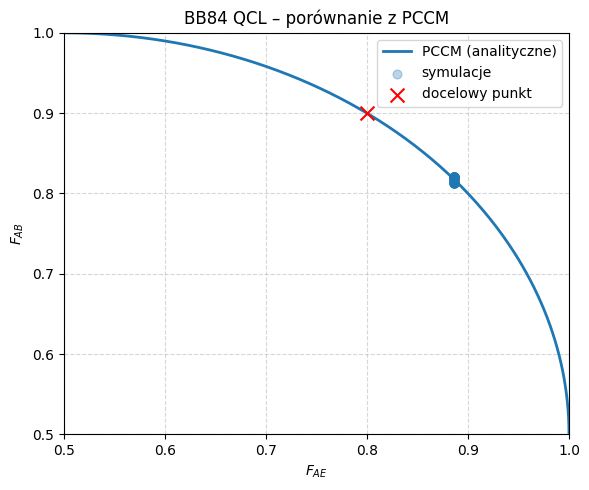

In [15]:
plt_fab_fae(b_q, e_q, 0.9)

### Wynik: Alice i Bob nie byli w stanie nadrobić strat spowodowanych przez Eve

# Końcowy obwód

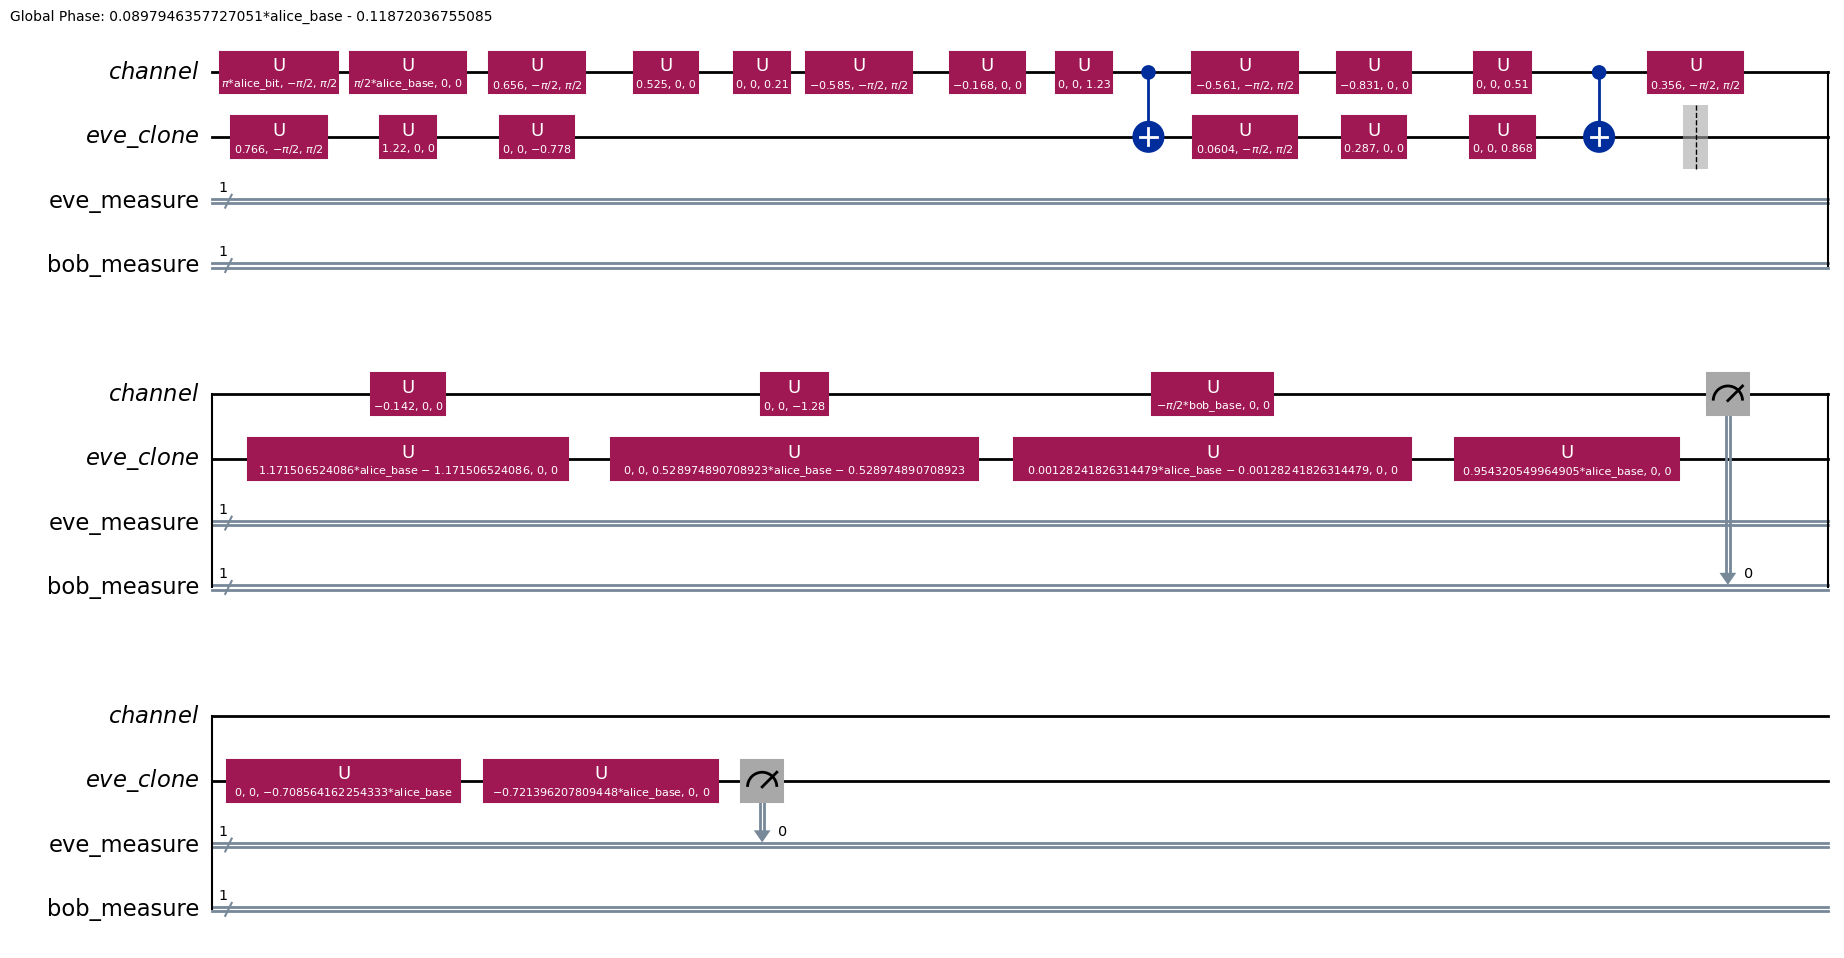

In [17]:
protocol._qc.assign_parameters(protocol.get_all_parameters()).draw("mpl")